#### **10.3** Simulation and Analysis of the Simplest Possible Site-Occupancy Model.

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as st

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
M = 100
J = 2
y = np.zeros((M, J))

# Parameter values
psi = 0.8                    # Probability of occupancy or presence
p = 0.5                      # Probability of detection

# Generate presence/absence data (the truth)
z = st.binom.rvs(n = 1, p = psi, size = M)

# Generate detection/nondetection data (i.e. presence/absence measurements)
for j in range(J):
    y[:, j] = st.binom.rvs(n = 1, p = z * p, size = M)
    
print(sum(z))
print(np.max(y, axis = 1).sum())

81
63.0


#### Model in BUGS language
```r
sink("model.txt")
cat("
model {
  # Priors
  psi ~ dunif(0, 1)
  p ~ dunif(0, 1)
  # Likelihood
  for (i in 1:M) {            # Loop over sites
    z[i] ~ dbern(psi)         # State model
    for (j in 1:J) {          # Loop over replicate surveys
      y[i,j] ~ dbern(z[i]*p)  # Observation model
    }
  }
}
",fill = TRUE)
sink()
```

In [3]:
index = np.repeat(np.arange(100), J).flatten().reshape(-1,1)
y_flat = y.flatten().reshape(-1,1) 
yst = np.max(y, axis = 1)

In [4]:
with pm.Model() as model_10_3:
    
    psi = pm.Uniform('psi', 0, 1)
    p = pm.Uniform('p', 0, 1)
    z = pm.Bernoulli('z', psi, shape = 100, initval = yst)
    prob = z[index] * p
    y_pred = pm.Bernoulli('y_pred', prob, observed = y_flat)
    
    trace_10_3 = pm.sample(4000, tune = 3000, return_inferencedata = True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p, psi]
>BinaryGibbsMetropolis: [z]


Sampling 2 chains for 3_000 tune and 4_000 draw iterations (6_000 + 8_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.9163603633165198, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [5]:
az.summary(trace_10_3, var_names = ['p', 'psi'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.532,0.061,0.416,0.640,0.002,0.002,661.0,1427.0,1.0
psi,0.810,0.083,0.663,0.972,0.003,0.003,566.0,582.0,1.0


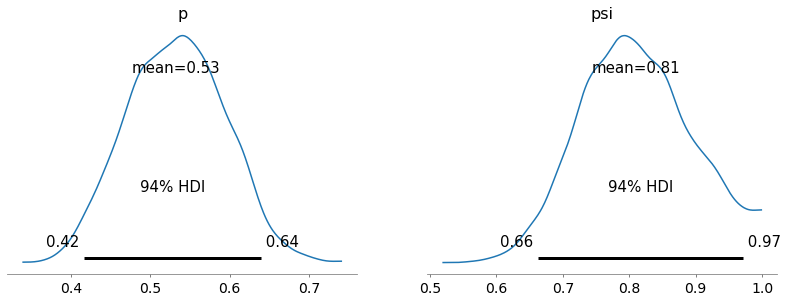

In [7]:
az.plot_posterior(trace_10_3, var_names = ['p', 'psi']);

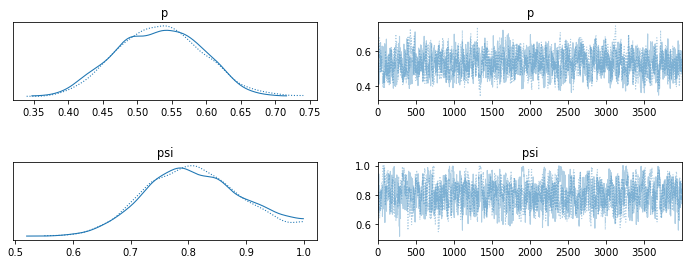

In [8]:
az.plot_trace(trace_10_3, var_names = ['p', 'psi'])
plt.subplots_adjust(hspace = 0.8, wspace=0.2);